In [1]:
import openmc_sinbad_benchmarks as osb
import os
import helpers
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
cwd = os.getcwd()

In [3]:
# read sinbad data
experiment_file = osb.ResultsFromDatabase('experiment_1.h5')
mcnp_eff3_file = osb.ResultsFromDatabase('mcnp_eff3_1.h5')
mcnp_fendl1_file = osb.ResultsFromDatabase('mcnp_fendl1_1.h5')
mcnp_fendl2_file = osb.ResultsFromDatabase('mcnp_fendl2_1.h5')

In [4]:
# functions for postprocessing and visualization
def _get_floor_ceiling(values):
    """Finds the global minimum and maximum values that can be used to frame a plot

    Args:
        values (array): values that will be plotted

    Returns:
        float, float: global minimum and global maximum values present in the input array
    """

    min_value = np.nanmin([np.nanmin(i) for i in values])
    max_value = np.nanmax([np.nanmax(i) for i in values])
    min_oom = math.floor(math.log(min_value, 10))
    max_oom = math.floor(math.log(max_value, 10))
    return 10**(min_oom),  10**(max_oom+1)


def mean(dataset):
    return dataset['mean']


def std_dev(dataset):
    return dataset['std. dev.']


def rel_std_dev(dataset):
    return dataset['std. dev.'] / dataset['mean']


def mean_ratio(dataset_1, dataset_2):
    return dataset_1 / dataset_2


def _3sigma_area(ax, ticks, std_dev):
    """Generates errorbars as grey areas on existing plot

    Args:
        ax (matplotlib.pyplot.axes): plot already existing
        ticks (array): array of values desctibing the plot xaxis
        std_dev (array): values corresponding to 1 standard deviation
    """
    # plotting the three grey areas
    ax.fill_between(ticks, 1 - std_dev, 1 + std_dev, color='k', alpha=.1)
    ax.fill_between(ticks, 1 - 2*std_dev, 1 + 2*std_dev, color='k', alpha=.1)
    ax.fill_between(ticks, 1 - 3*std_dev, 1 + 3*std_dev, color='k', alpha=.1)


def _print_3sigma(ax, mean, std_dev, ticks):
    """Generates the 1,2,3simga strings near the grey areas for an existing plot

    Args:
        ax (matplotlib.pyplot.axes): plot already existing
        mean (array): values corresponding to the mean
        std_dev (array): values corresponding to 1 standard deviation
        ticks (array): array of values desctibing the plot xaxis
    """
    # get index of last valid value for measured data for placing 1,2,3sigma strings near the grey areas
    sigma_index = (~np.isnan(mean)).cumsum(0).argmax(0)
    last_sigma = std_dev[sigma_index]

    # trying to avoid interference between the 3 strings
    if last_sigma < .08:
        last_sigma = .08
        sigma_start = .93

    # string annootation in the plot
    ax.annotate('1\u03C3', [ticks[sigma_index] + 0.07,
                1. + 1*last_sigma], fontsize=10, clip_on=False)
    ax.annotate('2\u03C3', [ticks[sigma_index] + 0.07,
                1. + 2*last_sigma], fontsize=10, clip_on=False)
    ax.annotate('3\u03C3', [ticks[sigma_index] + 0.07,
                1. + 3*last_sigma], fontsize=10, clip_on=False)


class VisualizeResults:
    """Embeds all necessary functions for plotting results and C/E results for comparison
    __init__() already generates the plot istance
    """

    def __init__(self):

        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5),
                                       gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

        self.fig = fig
        self.ax1 = ax1
        self.ax2 = ax2

    def add_measured_data(self, measured_data, xlabel, ylabel: str, dtype_label=''):
        """Includes measured data in the already existing plot generated in the class initialization

        Args:
            measured_data (dataframe or dataset): table with the measured data, it has to have the 'y(cm)', 'mean' and 'std. dev.' columns
            ylabel (str): string to write in the plot ylabel (ax.set_ylabel() will be used)
            dtype_label (str, optional): string printed in the plot for possible additional information (e.g. tally type or reaction type). Defaults to ''.
        """

        self.measured_data = measured_data
        self.tickers = np.arange(len(measured_data))

        # get all values in plot-friendly format
        measured_rstd = rel_std_dev(measured_data)

        # # some data are already strings other have to be decoded
        # try:
        #     my_xlabels = [el.decode() for el in measured_data['y(cm)']]
        # except AttributeError:
        #     my_xlabels = measured_data['y(cm)']

        my_xlabels = [el.decode() for el in measured_data[xlabel]]

        # get data floor and ceiling for plot framing
        floor, ceiling = _get_floor_ceiling([measured_data['mean']])

        # plot
        self.ax1.set_yscale('log')
        self.ax1.set_ylim([floor, ceiling])
        self.ax1.set_xticks(self.tickers)
        self.ax1.tick_params(axis='x', labelbottom=False)
        self.ax1.tick_params(axis='both', which='both', direction='in')
        self.ax1.set_ylabel(ylabel, fontsize=12)
        # add errorbars as grey areas and 1,2,3sigma strings
        _3sigma_area(self.ax2, self.tickers, measured_rstd)
        _print_3sigma(
            self.ax2, measured_data['mean'], measured_data['std. dev.'], self.tickers)
        # add C/E=1 line for showing target value
        self.ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
                        linewidth=1, label='_nolegend_')
        self.ax2.set_xlim([-0.5, self.tickers[-1] + .6])
        self.ax2.set_ylim([0.5, 1.5])
        self.ax2.set_xticks(self.tickers)
        self.ax2.set_xticklabels(my_xlabels)
        self.ax2.tick_params(axis='x', labelrotation=45)
        self.ax2.tick_params(axis='both', which='both', direction='in')
        self.ax2.set_xlabel('Position (cm)', fontsize=12)
        self.ax2.set_ylabel('C/E', fontsize=12)
        self.ax2.annotate(dtype_label, [0.02, 0.07], xycoords='axes fraction',
                          horizontalalignment='left', verticalalignment='bottom', fontsize=12)

        self.ax1.plot(self.tickers, self.measured_data['mean'], marker='s', ms=10,
                      ls='none', mew=1.5, mec='k', mfc='none', alpha=1, label='Experiment')

    def add_computed_data(self, dataset, marker='o', color='tab:red', label=''):
        """Includes computed data in the already existing plot generated in the class initialization

        Args:
            dataset (dataframe or dataset): table with the computed data, it has to have the 'y(cm)', 'mean' and 'std. dev.' columns
            marker (str, optional): matplotlib marker type. Defaults to 'o'.
            color (str, optional): matplotlib color. Defaults to 'tab:red'.
            label (str, optional): matplotlib label for legend. Defaults to ''.
        """

        # try/except statements are necessary in the case the user did not do every type of simulation but just some
        try:
            rstd = rel_std_dev(dataset)
            ce = mean_ratio(dataset['mean'], self.measured_data['mean'])

            floor, ceiling = _get_floor_ceiling(
                [self.measured_data['mean'], np.array(dataset['mean'])])

            self.ax1.set_ylim([floor, ceiling])
            self.ax1.plot(self.tickers, dataset['mean'], marker=marker,
                          ms=7, ls='none', alpha=1, color=color, label=label)
            self.ax2.errorbar(self.tickers, ce, rstd*ce, marker=marker, ms=6, capsize=4,
                              barsabove=True, zorder=9, color=color, ls='none', label='_label')
            self.ax1.legend(frameon=True, fontsize=12)
        except:
            pass



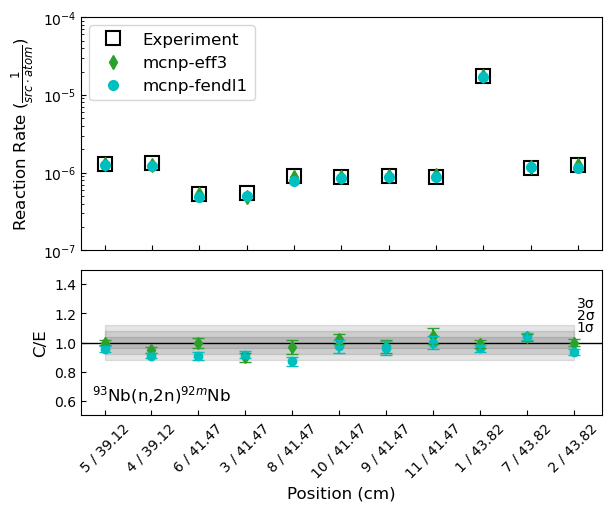

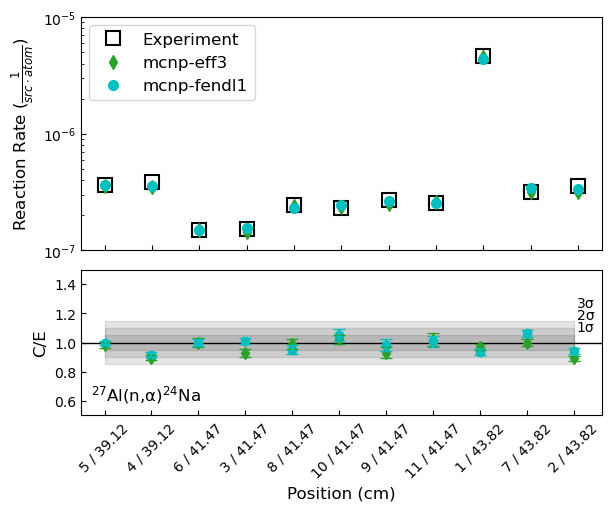

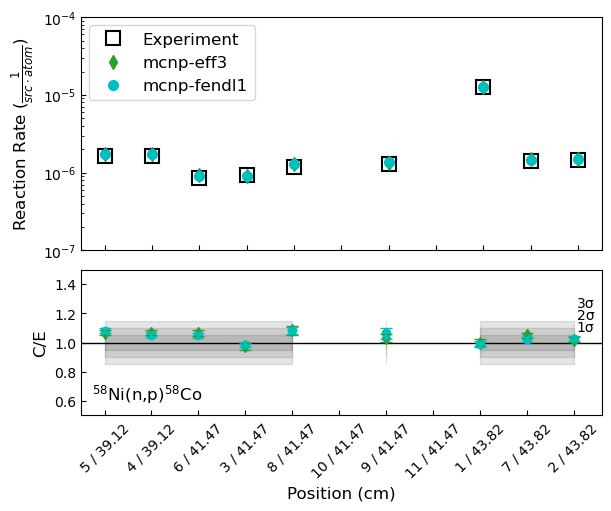

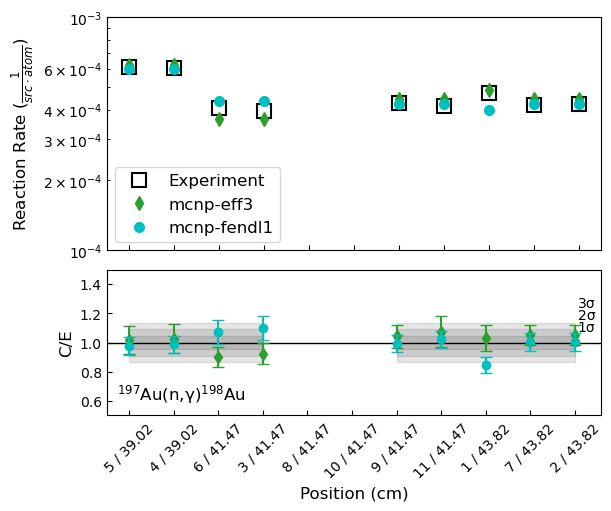

In [5]:
# initialization
foil_list = ['nb93', 'al27', 'ni58', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', '$^{58}$Ni(n,p)$^{58}$Co', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

for i,foil in enumerate(foil_list):

    xaxis_label = experiment_file.get_tally(f'rr_onaxis1_{foil}').get_xaxis_label()

    measured = experiment_file.get_tally(f'rr_onaxis1_{foil}').get_pandas_dataframe()
    mcnp_eff3 = mcnp_eff3_file.get_tally(f'rr_onaxis1_{foil}').get_pandas_dataframe()
    mcnp_fendl1 = mcnp_fendl1_file.get_tally(f'rr_onaxis1_{foil}').get_pandas_dataframe()

    try:
        mcnp_fendl2 = mcnp_fendl2_file.get_tally(f'rr_onaxis1_{foil}')
    except:
        mcnp_fendl2 = None

    
    # # read openmc results from its statepoint file
    # openmc_1 = helpers.get_openmc_tally('reaction_rates_onaxis', 'statepoint.100.h5', f'{foil}_irdff_rr')
    # openmc_1 = helpers.postprocess_openmc_foils(openmc_1, 'onaxis_group1')
    
    # plot
    dtype_label = reaction_labels[i]
    foils_onaxis_group1 = helpers.VisualizeResults()  # the plot has always to be initialized like this
    foils_onaxis_group1.add_measured_data(measured, xaxis_label, ylabel, dtype_label)  # measured data have always to be plotted
    foils_onaxis_group1.add_computed_data(mcnp_eff3, 'd', 'tab:green', 'mcnp-eff3')  # one can add as many computed data as preferred
    foils_onaxis_group1.add_computed_data(mcnp_fendl1, 'o', 'c', 'mcnp-fendl1')
    foils_onaxis_group1.add_computed_data(mcnp_fendl2, '^', 'tab:pink', 'mcnp-fendl2')
    # foils_onaxis_group1.add_computed_data(openmc_1, 'x', 'crimson', 'openmc')